Nodes: 48 Edges: 82
Total travel time (all agents) before intervention (s): 278970.75
Total travel time (all agents) after adding flyover (s): 268151.58
Change in total travel time (s): 10819.17

Simple Report:
Total agents simulated: 1200
Total travel time BEFORE: 77.49 hours
Total travel time AFTER : 74.49 hours
Estimated time saved  : 3.005 hours across all agents

Saved map to /content/digital_twin_flyover_map.html — open or download to view.


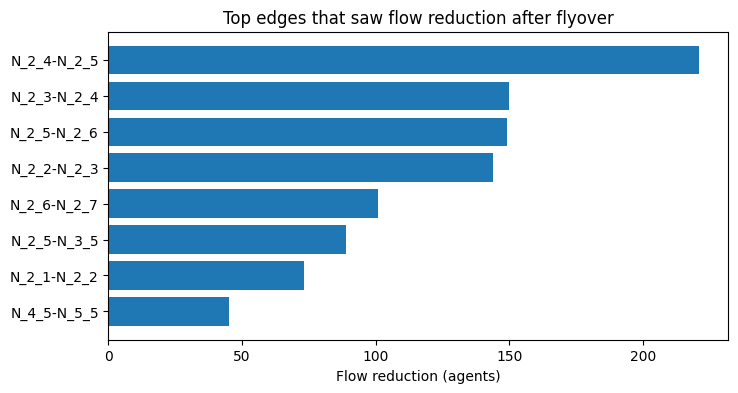

In [ ]:
# Digital Twin: simple urban traffic simulation + "add flyover" scenario
# Run in Colab (or a local Python env). Installs below are minimal.

# 1) Installs
!pip install -q folium networkx numpy pandas matplotlib

# 2) Imports
import networkx as nx
import numpy as np
import pandas as pd
import folium
from folium import PolyLine
from math import hypot
import random
from IPython.display import HTML, display
import matplotlib.pyplot as plt

# -------------------------
# 3) Build a synthetic grid road network (nodes have lat/lon)
# -------------------------
def build_grid_graph(rows=6, cols=8, spacing_deg=0.005, origin=(19.0,72.80)):
    G = nx.Graph()
    o_lat, o_lon = origin
    for r in range(rows):
        for c in range(cols):
            nid = f"N_{r}_{c}"
            lat = o_lat + r * spacing_deg
            lon = o_lon + c * spacing_deg
            G.add_node(nid, lat=lat, lon=lon, row=r, col=c)
    # connect 4-neighbors
    for r in range(rows):
        for c in range(cols):
            u = f"N_{r}_{c}"
            for dr,dc in [(1,0),(0,1)]:  # down, right to avoid duplicates
                rr, cc = r+dr, c+dc
                if 0 <= rr < rows and 0 <= cc < cols:
                    v = f"N_{rr}_{cc}"
                    # euclidean approx distance (degrees -> meters ~111000 per deg)
                    lat1, lon1 = G.nodes[u]['lat'], G.nodes[u]['lon']
                    lat2, lon2 = G.nodes[v]['lat'], G.nodes[v]['lon']
                    meters = hypot((lat1-lat2)*111000, (lon1-lon2)*111000)
                    # baseline free-flow speed (km/h)
                    free_speed_kmph = 40.0
                    travel_time_s = meters / (free_speed_kmph * 1000/3600)
                    # store attributes
                    G.add_edge(u, v,
                               length_m=meters,
                               free_time_s=travel_time_s,
                               time_s=travel_time_s,
                               flow=0.0)
    return G

G = build_grid_graph(rows=6, cols=8)
print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

# -------------------------
# 4) Generate random agents (origin-destination pairs)
# -------------------------
def generate_agents(G, n_agents=800, seed=42):
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes())
    agents = []
    for i in range(n_agents):
        o, d = rng.choice(nodes), rng.choice(nodes)
        while d == o:
            d = rng.choice(nodes)
        agents.append({'id': f"A{i}", 'o': o, 'd': d})
    return pd.DataFrame(agents)

agents = generate_agents(G, n_agents=1200)

# -------------------------
# 5) Simple assignment: compute shortest paths and accumulate flows
# -------------------------
def reset_flow(G):
    for u,v,data in G.edges(data=True):
        data['flow'] = 0.0
        data['time_s'] = data['free_time_s']

def assign_flows(G, agents, iterate=False, capacity_m=2000.0):
    """
    Simple static assignment:
      - compute shortest path by current edge time_s
      - increment flow on edges
      - optionally iterate to reflect congestion (BPR-like link travel time)
    """
    reset_flow(G)
    # initial assignment
    for idx, a in agents.iterrows():
        try:
            path = nx.shortest_path(G, a['o'], a['d'], weight='time_s')
        except nx.NetworkXNoPath:
            continue
        # increment flow on each edge in path
        for u,v in zip(path, path[1:]):
            G[u][v]['flow'] += 1.0
    # optionally do a few iterations to update time_s based on flow (BPR-style)
    if iterate:
        for it in range(4):
            # update times: simple function t = t0 * (1 + alpha*(flow/cap)^beta)
            alpha, beta = 0.15, 4.0
            for u,v,data in G.edges(data=True):
                # capacity proportional to link length (very rough); ensure capacity > 0
                cap = max(100.0, capacity_m * (data['length_m']/100.0))
                vo_ratio = (data['flow'] / cap)
                data['time_s'] = data['free_time_s'] * (1 + alpha * (vo_ratio ** beta))
            # recompute assignment with updated times (all-or-nothing)
            # reset flows, reassign
            for u,v in G.edges():
                G[u][v]['flow'] = 0.0
            for idx, a in agents.iterrows():
                try:
                    path = nx.shortest_path(G, a['o'], a['d'], weight='time_s')
                except nx.NetworkXNoPath:
                    continue
                for u,v in zip(path, path[1:]):
                    G[u][v]['flow'] += 1.0
    # final result stored in G edges
    return G

# Run assignment before any intervention
G_before = assign_flows(G, agents, iterate=True)

# helper to compute total travel time experienced by all agents
def total_travel_time(G, agents):
    total_s = 0.0
    for idx, a in agents.iterrows():
        try:
            path = nx.shortest_path(G, a['o'], a['d'], weight='time_s')
        except nx.NetworkXNoPath:
            continue
        # sum edge times along path
        for u,v in zip(path, path[1:]):
            total_s += G[u][v]['time_s']
    return total_s

t_before = total_travel_time(G_before, agents)
print("Total travel time (all agents) before intervention (s):", round(t_before,2))

# -------------------------
# 6) Add a flyover: insert a high-speed long link between chosen nodes
# -------------------------
def add_flyover(G, node_a, node_b, speed_kmph=80.0):
    # compute geometric distance and create edge with very high speed
    lat1, lon1 = G.nodes[node_a]['lat'], G.nodes[node_a]['lon']
    lat2, lon2 = G.nodes[node_b]['lat'], G.nodes[node_b]['lon']
    meters = hypot((lat1-lat2)*111000, (lon1-lon2)*111000)
    travel_time_s = meters / (speed_kmph * 1000/3600)
    # add the link (if exists, update)
    G.add_edge(node_a, node_b,
               length_m=meters,
               free_time_s=travel_time_s,
               time_s=travel_time_s,
               flow=0.0,
               flyover=True)
    return G

# pick endpoints for new flyover (e.g., top-left to top-right of middle rows)
node_a = "N_2_0"
node_b = "N_2_7"
G_with_fly = G.copy()
G_with_fly = add_flyover(G_with_fly, node_a, node_b, speed_kmph=100.0)

# reassign flows with the flyover present
G_after = assign_flows(G_with_fly, agents, iterate=True)
t_after = total_travel_time(G_after, agents)
print("Total travel time (all agents) after adding flyover (s):", round(t_after,2))
print("Change in total travel time (s):", round(t_before - t_after,2))

# -------------------------
# 7) Simple report
# -------------------------
print("\nSimple Report:")
print(f"Total agents simulated: {len(agents)}")
print(f"Total travel time BEFORE: {t_before/3600:.2f} hours")
print(f"Total travel time AFTER : {t_after/3600:.2f} hours")
print(f"Estimated time saved  : {(t_before - t_after)/3600:.3f} hours across all agents\n")

# Edge flow comparison for visualization
edge_rows = []
for u,v,data in G_before.edges(data=True):
    key = (u,v)
    flow_b = G_before[u][v]['flow']
    flow_a = G_after[u][v]['flow'] if G_after.has_edge(u,v) else 0.0
    length = data['length_m']
    fly = data.get('flyover', False)
    lat1,lon1 = G_before.nodes[u]['lat'], G_before.nodes[u]['lon']
    lat2,lon2 = G_before.nodes[v]['lat'], G_before.nodes[v]['lon']
    edge_rows.append({
        'u':u,'v':v,'lat1':lat1,'lon1':lon1,'lat2':lat2,'lon2':lon2,
        'flow_before':flow_b,'flow_after':flow_a,'length_m':length,'flyover':fly
    })
# include new flyover edge if not in original iteration list
if G_after.has_edge(node_a,node_b) and not any((r['u']==node_a and r['v']==node_b) for r in edge_rows):
    d = G_after[node_a][node_b]
    edge_rows.append({
        'u':node_a,'v':node_b,'lat1':G_after.nodes[node_a]['lat'],'lon1':G_after.nodes[node_a]['lon'],
        'lat2':G_after.nodes[node_b]['lat'],'lon2':G_after.nodes[node_b]['lon'],
        'flow_before':0.0,'flow_after':d['flow'],'length_m':d['length_m'],'flyover':True
    })

edges_df = pd.DataFrame(edge_rows)

# -------------------------
# 8) Visualize with Folium map (colors by delta flow)
# -------------------------
# Center map
avg_lat = np.mean([d['lat'] for n,d in G.nodes(data=True)])
avg_lon = np.mean([d['lon'] for n,d in G.nodes(data=True)])
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=13)

# plot nodes
for n,d in G.nodes(data=True):
    folium.CircleMarker(location=[d['lat'],d['lon']],
                        radius=3, color='black', fill=True).add_to(m)

# plot edges: thickness by flow after, color by flow change
for idx,row in edges_df.iterrows():
    lat1,lon1,row_lat2,row_lon2 = row['lat1'],row['lon1'],row['lat2'],row['lon2']
    flow_b, flow_a = row['flow_before'], row['flow_after']
    delta = flow_a - flow_b
    # color scale
    if row['flyover']:
        color = 'blue'
        weight = 5
    else:
        color = 'green' if delta < 0 else 'red'
        weight = 1 + min(8, max(1, abs(delta)/50.0))
    PolyLine(locations=[(lat1,lon1),(row_lat2,row_lon2)], color=color, weight=weight, opacity=0.7).add_to(m)

# Save map
m.save("/content/digital_twin_flyover_map.html")
print("Saved map to /content/digital_twin_flyover_map.html — open or download to view.")

# Display simple matplotlib bar of top edges with reduction in flow
edges_df['delta_flow'] = edges_df['flow_before'] - edges_df['flow_after']
top_savings = edges_df.sort_values('delta_flow', ascending=False).head(8)
plt.figure(figsize=(8,4))
plt.barh(top_savings.apply(lambda r: f"{r.u}-{r.v}",axis=1), top_savings['delta_flow'])
plt.xlabel("Flow reduction (agents)")
plt.title("Top edges that saw flow reduction after flyover")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# Simple Digital Twin Simulation Prototype

def simulate_digital_twin():
    print("🏙️ Welcome to the Urban Planning Digital Twin")
    print("You can test city policies like:")
    print("1. Add flyover")
    print("2. Increase public transport")
    print("3. Population growth")
    print("4. Build park/green cover")
    print("5. Exit\n")

    traffic = 50   # base traffic congestion (0-100 scale)
    pollution = 50 # base pollution level
    green_cover = 40 # percentage
    population = 1000000 # base population

    while True:
        choice = input("\nEnter your action (flyover/transport/population/park/exit): ").lower()

        if choice == "flyover":
            traffic -= 15
            print("✅ New flyover built! Traffic reduced.")

        elif choice == "transport":
            traffic -= 10
            pollution -= 5
            print("✅ Public transport improved! Less traffic & pollution.")

        elif choice == "population":
            population += 200000
            traffic += 10
            pollution += 5
            print("⚠️ Population increased! More traffic & pollution.")

        elif choice == "park":
            green_cover += 5
            pollution -= 10
            print("🌳 New park added! More green cover & cleaner air.")

        elif choice == "exit":
            print("\n📊 Final City Simulation Results:")
            print(f"Traffic Congestion: {traffic}/100")
            print(f"Pollution Level: {pollution}/100")
            print(f"Green Cover: {green_cover}%")
            print(f"Population: {population}")
            print("✅ Simulation Ended")
            break

        else:
            print("❌ Invalid choice, try again.")

# Run the simulation
simulate_digital_twin()

🏙️ Welcome to the Urban Planning Digital Twin
You can test city policies like:
1. Add flyover
2. Increase public transport
3. Population growth
4. Build park/green cover
5. Exit


Enter your action (flyover/transport/population/park/exit): flyover
✅ New flyover built! Traffic reduced.

Enter your action (flyover/transport/population/park/exit): park
🌳 New park added! More green cover & cleaner air.

Enter your action (flyover/transport/population/park/exit): park
🌳 New park added! More green cover & cleaner air.

Enter your action (flyover/transport/population/park/exit): population
⚠️ Population increased! More traffic & pollution.

Enter your action (flyover/transport/population/park/exit): flyover
✅ New flyover built! Traffic reduced.

Enter your action (flyover/transport/population/park/exit): exit

📊 Final City Simulation Results:
Traffic Congestion: 30/100
Pollution Level: 35/100
Green Cover: 50%
Population: 1200000
✅ Simulation Ended
